### Beers Have Style
Schwartzbier, real ale, wheat beer, Kölsch... many things can define a beer's style. In the professional brewing world, styles can be differentiated by appearance, flavor, ingredients, production method, history, or origin. Unfortunately, not everyone agrees on how to categorize beer styles, and brewers often flip flop their beers between categories for competitions and distributors in different parts of the world. For instance, take a look at differences between [CAMRA's Champion Beer of Britain](http://www.camra.org.uk/en_US/champion-beer-of-britain), the [Beer Judge Certification Program (BJCP)](https://www.bjcp.org/), the [Brewers Association's World Beer Cup](https://www.worldbeercup.org/)). Furthermore, new styles are invented all the time as breweries try to differentiate their creations, and angsty beer geeks are given reason to wage sudsy wars in online forums. But even the most time-honored styles were once new (even lagers were invented less than 200 years ago). Our preferences both shape and are shaped by this long, organic process.

Meanwhile, back at the brewery, a brewer is mindfully formulating and testing beer according to precise scientific standards. This precision ensures that a Sierra Nevada Pale Ale tastes just as good no matter when or where you drink it. The subjective qualities of beer styles are transformed. Color is identified according to the Standard Reference Method (SRM), bitterness is quantified on the scale of International Bitterness Units (IBUs), and a beer's capacity for danger and fun is measured by its alcohol content (percentage of alcohol by volume, or ABV). Many other metrics exist, but these are the big three. Give a [Cicerone](https://www.cicerone.org) (beer sommelier) these three pieces of information, and he or she could probably tell you its style without even tasting it.

### Beer by Numbers
As a data scientist with a background in machine learning, I often daydream about the future of artificial intelligence. But sometimes my imagination interferes with another of my passions, the history and culture of beer. The other day, while studying for my [Certified Cicerone Exam](https://www.cicerone.org/us-en/certifications/certified-cicerone), I had a fascinating idea. If a brewer fed an artificially intelligent robot thousands of beers and asked it to come up with its own categories of style, what would they be? 

What would be left of beer if styles were defined quantitatively, based on SRM, IBU, and ABV alone?

### Categorizing Beer Styles with Machine Learning
Data science provides the tools to gather this beer data and feed it to a robot (i.e., a computer). Asking the computer to find structure within a collection of unlabeled data perfectly describes an unsupervised machine learning problem. We'll provide a long list of beers' SRM, IBU, and ABV metrics, and see if the computer can differentiate different categories, or "clusters", of beer. [Python 3.5](https://python.org) is my preferred language for data analysis because of its wide variety of powerful, open-source packages.

I assume you're not here to get slapped with lines of code, so I streamlined a part of this analysis with a small Python package I created called <tt>bdb_utils</tt>. Don't worry, the fun stuff is still on this page. But feel free to look into <tt>bdb_utils</tt> on [my Github](https://github.com/mrstepanovic/suds/blob/master/bdb_utils.py). If you're interested in learning more about clustering methods, check out this tutorial from the [Polytechnic Institute of Milan](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/).

#### Collecting Data
Beer data was collected from [BreweryDB](http://www.brewerydb.com/)'s web API, a moderated, crowd-sourced database of beer releases in development since 2009. I've been playing with it for just about three weeks and love it for its squeaky-clean data. 

In [5]:
import pandas as pd
import requests
import json

import bdb_utils

In [278]:
# Add your BreweryDB API key here.
API_KEY = ""
URL = "http://api.brewerydb.com/v2/beers/"

# Set parameters for BreweryDB's API.
params = dict(key=API_KEY, withBreweries='Y')

# Attempt to download 10,000 randomly-chosen beers from the database.
# Only beers with complete SRM, IBU, and ABV data will be collected.
beer_data = bdb_utils.download_data(URL, params, 10000, True)

# Also, save the data to a .csv for safe keeping offline.
beer_data.to_csv("beer_data.csv")

### Exploring the Data

I'm a big fan of trivia and like to pretend I'm gathering trivia facts during exploratory data analysis (EDA). I'm also checking various statistical assumptions we might subject the data to later. 

#### Trivia Question 1
How many unique beers and styles were collected?

In [61]:
number_of_beers = len(beer_data)
number_of_styles = beer_data['Style'].nunique()

print("{} beers of {} styles were collected.".format(number_of_beers, number_of_styles))

5513 beers of 146 styles were collected.


Over 5,000! Prost.

#### Trivia Question 2
What are the top 10 most popular styles?

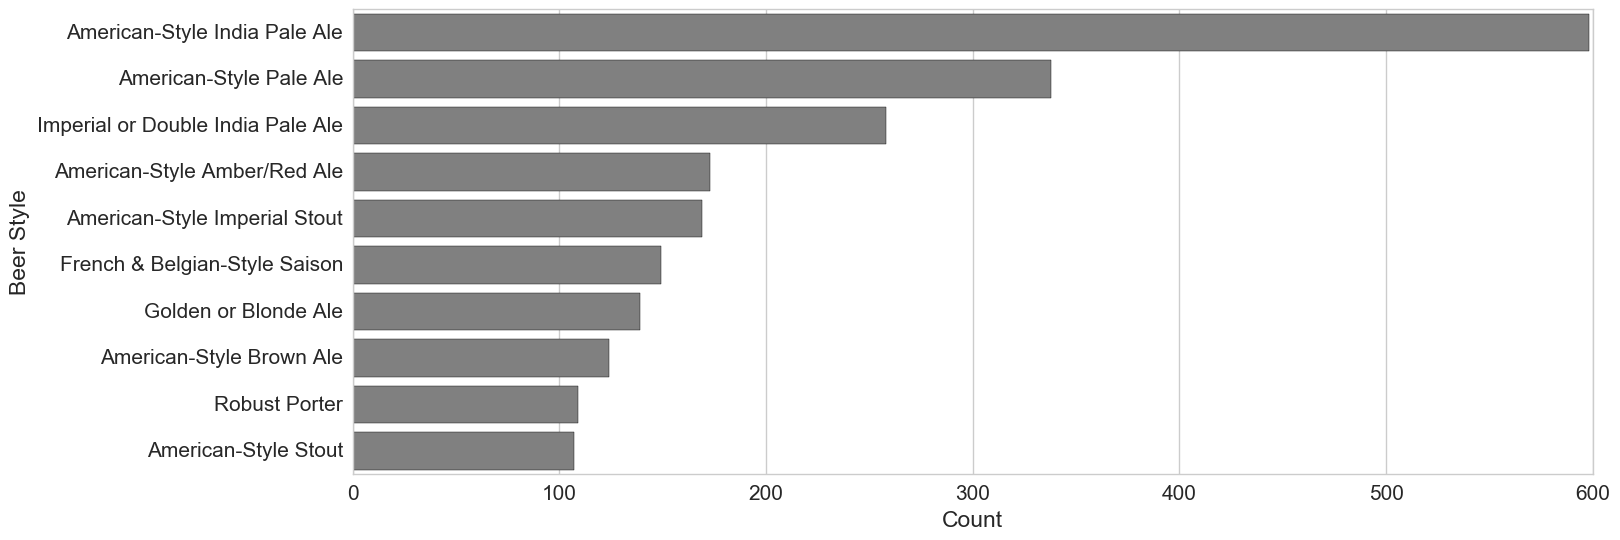

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Count the N most frequent beer styles in the dataset.
def top_n_styles(N):
    return pd.value_counts(beer_data['Style']).iloc[:N].index

top_ten = top_n_styles(10)

# Create bar plot with N styles.
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
fig1 = plt.figure(figsize=(16, 6))
ax = sns.countplot(y="Style", data=beer_data, color='gray', order=top_ten)
ax.set(xlabel='Count', ylabel='Beer Style');

American IPAs dominate the dataset by a landslide, followed by American Pale Ales and Imperial/Double IPAs. I'm assuming that most contributors to BreweryDB are American, and beer-conscious Americans have a hop obsession. Lagers and malt-heavy styles have traditionally dominated most of Europe. The malt vs. hops war is currently in [full swing](http://www.sfexaminer.com/stop-pretending-like-ipas/).

#### Trivia Question 3
What is the distribution of each beer metric?

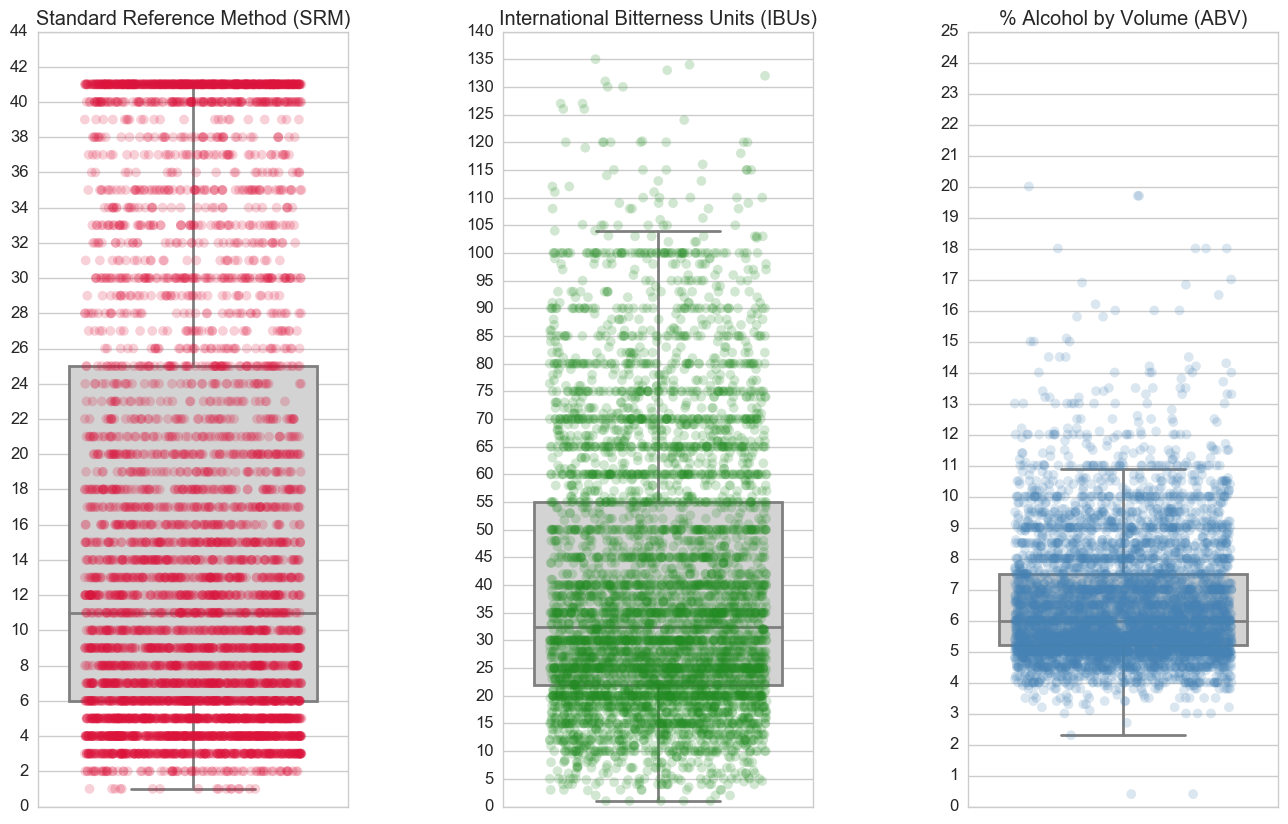

In [63]:
# Set seaborn style parameters.
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

# Create a boxplot with seaborn.
def make_boxplot(column, axis, color='lightgray', df=beer_data):
    sns.boxplot(data=df, y=column, ax=axis, color=color, linewidth=2, width=0.8, showfliers=False)

# Create a strip plot with seaborn.
def make_stripplot(column, axis, color='purple', df=beer_data):
    sns.stripplot(data=df, y=column,ax=axis, jitter=.35, color=color, size=7,  alpha=.2)

# Create a figure with 3 subplots side-by-side.
fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,10))
fig2.subplots_adjust(wspace=0.5)

# Turn off axis labels.
for ax in [ax1, ax2, ax3]:
    ax.yaxis.label.set_visible(False)

# Create the SRM subplot figure.
ax1.set(ylim=(0, 44), yticks=(np.arange(0, 45, 2)), title="Standard Reference Method (SRM)")
make_boxplot("SRM", ax1)
make_stripplot("SRM", ax1, color='crimson')

# Create the IBU subplot figure.
ax2.set(ylim=(0, 140), yticks=(np.arange(0, 141, 5)), title="International Bitterness Units (IBUs)")
make_boxplot("IBU", ax2)
make_stripplot("IBU", ax2, color='forestgreen')

# Create the ABV subplot figure.
ax3.set(ylim=(0, 25), yticks=(np.arange(0, 26, 1)), title="% Alcohol by Volume (ABV)")
make_boxplot("ABV", ax3)
make_stripplot("ABV", ax3, color='steelblue')

I like using box plots to quickly visualize centrality measures in a dataset. To squeeze even more information about the distribution of each variable, I've layered all 5,000+ data points atop the box plots as jittered strip plots. We see that each variable is distributed asymmetrically, with outliers lending to a long-tailed positive skew. Unlike IBU and ABV, SRM is an interval variable with discrete values, which we see as distinct "rungs" in its plot. We also see a high frequency of datapoints at the top of the SRM scale, which likely represents noise in the dataset. I assume many brewers want to push themselves to concoct suds with the darkest malt possible. It's kind of like a badge of honor, and it's hella rad in the cold months. Alternatively, people might not be so adept at distinguishing between SRM values towards the top of the scale.

## Clustering

Now that we know a little bit about our beer data, let's feed it to a robot. I'll try this with two different clustering algorithms, [each of which has plusses and minuses](http://nbviewer.jupyter.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb). The first one I'll try is the most popular and most intuitive: the k-means algorithm implemented in `sklearn`. The K-means algorithm tries sort samples into K different groups of equal variance.

I'll need to preprocess the data because each variable uses its own proprietary unit of measure. It's not intuitive to think of IBU in terms of SRM, for example.

In [28]:
from sklearn.preprocessing import StandardScaler

# Preprocess data by subtracting mean and scaling to unit variance.
beer_measures = beer_data.as_matrix(columns=['SRM', 'IBU', 'ABV'])
X = StandardScaler().fit_transform(beer_measures)

In order to perform a k-means clustering analysis, we have to give the computer a hint about how many clusters it needs to find. There's no definitive way to know this, so we must rely on what we think is reasonable based on our assumptions about beer and the data we have. Based on SRM, IBU, and ABV alone, I think the computer will find a maximum of 20 discernable clusters. I'll iteratively try them all with `sklearn.cluster.KMeans` and use the elbow plot method, which illustrate what percentage of the data's variance is explained by choosing K number of clusters.

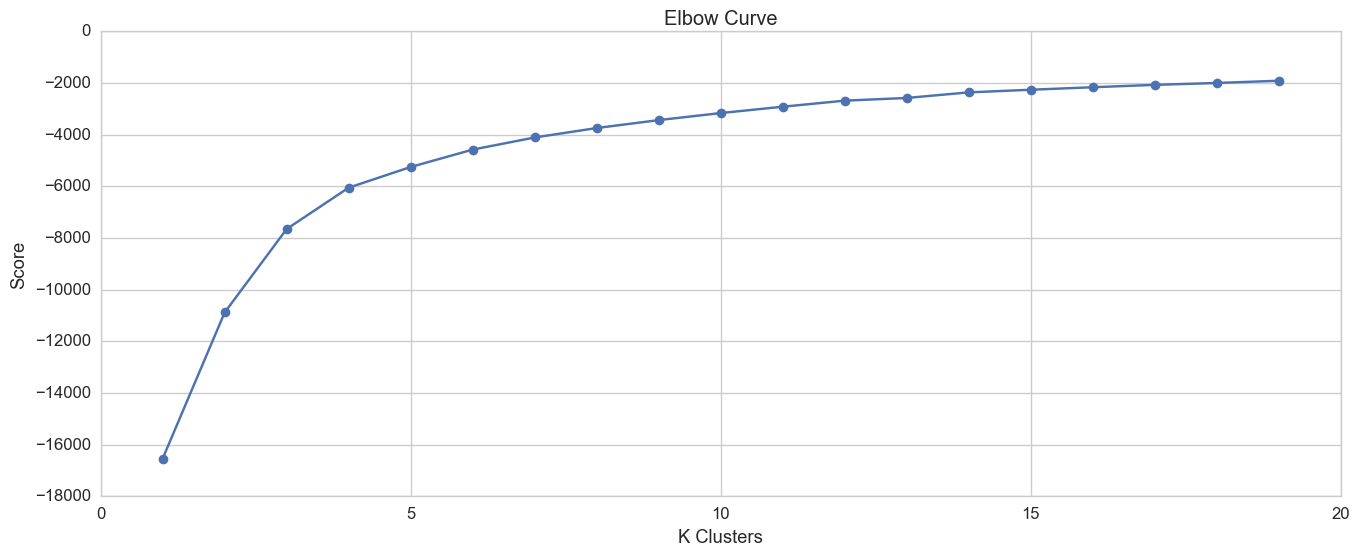

In [64]:
from sklearn.cluster import KMeans

# Calculate k-means fit for all Ks from 1 to 20.
k = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in k]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

# Plot the k-means score (percent variance explained) for each K.
fig = plt.figure(figsize=(16, 6))
plt.plot(k, score, '-o')
plt.xlabel('K Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve');

The elbow method tells us to look to where the percent of variance explained (in this case, the score) reduces sharply with increasing K. It looks like that value is somewhere between 4 and 12 clusters. 

I'll look at a second algorithm, Hierarchical Density-Based Spatial Clustering of Applications with Noise or [HDBSCAN](https://github.com/lmcinnes/hdbscan), which defines clusters as regions of high density surrounded by regions of low density. The algorithm requires one parameter for the minimum number of samples required to define a cluster. Based on my domain knowledge of beer (and our plot above), I used `min_samples=20`.

In [78]:
# Import beta HDBSCAN implementation, a part of scikit-learn-contrib.
import hdbscan

# Identify number of clusters where minimum cluster size = 20.
hdb = hdbscan.HDBSCAN(min_cluster_size=20).fit(X)
n_clusters_ = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 5


HDBSCAN identified 5 clusters of minimum size 20, but we don't yet know what differentiates them. It would be interesting to visualize where the clusters are grouped along SRM, IBU, and ABV dimensions. 

### Results

I used Plotly to make a [3D Scatterplot](https://plot.ly/python/3d-scatter-plots/) that visualizes the way that our unsupervised machine learning algorithm categorizes beers. I colored points according to their cluster neighborhood, also connecting them with a mesh. Beers that don't easily fit any of the five clusters were coded as noise and appear in light gray. Hovering over any datapoint will reveal information about its style and quantitative characteristics (x=SRM, y=IBU, z=ABV). Note that some beers with extreme values do not appear here.

In [95]:
import plotly.plotly as py
import plotly.graph_objs as go

# Use the five clusters identified by HDBSCAN
k = 5
colors = ["crimson", "steelblue", "forestgreen", "gold", "lavender"]

# Create 3D scatterplot parameters for Plotly.
def make_cluster_points(name, cluster_df, color, size=4, opacity=1):
    return dict(mode="markers", 
                name=name, 
                type='scatter3d',
                text=cluster_df.as_matrix()[:,2],
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                marker=dict(size=size, color=color, opacity=opacity))

# Create 3D mesh to encapsulate clusters for Plotly.
def make_cluster_mesh(name, cluster_df, color):
    return dict(alphahull=0,
                name=name,
                opacity=0.1,
                type="mesh3d",    
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                color=color,
                showscale=False)

# Set Plotly 3d scatter and mesh params over k iterations (clusters).
def make_plot_parameters(k):
    clusters = {}
    points = {}
    meshes = {}
    for x in range(k):
        clusters[x] = beer_data.loc[beer_data['cluster'] == x]
        points[x] = make_cluster_points("Cluster {}".format(x+1), clusters[x], colors[x])
        meshes[x] = make_cluster_mesh("Cluster {}".format(x+1), clusters[x], colors[x])
    return clusters, points, meshes

# Fit cluster estimates with HDBSCAN and create a new column with 
# cluster labels in the raw pandas dataframe.
db_est = hdbscan.HDBSCAN(min_cluster_size=20).fit(X)
beer_data['cluster'] = db_est.labels_

# Iterate over 5 clusters.
c, p, m = make_plot_parameters(k)
noise = make_cluster_points("Noise", beer_data, "lightgray", size=3, opacity=0.7)

# Set 3D scatter plot camera angle
camera = dict(up=dict(x=0, y=0, z=1), 
              center=dict(x=0, y=0, z=0), 
              eye=dict(x=-1.6, y=-1.6, z=0.5))

# Set parameters for 3D scatter plot layout.
layout = go.Layout(width=800, height=800, showlegend=False, margin=dict(r=20, l=20),
                   scene=dict(xaxis = dict(range = [0,45], title='SRM'),
                              yaxis = dict(range = [0,150], title='IBU'),
                              zaxis = dict(range = [0,20], title='ABV'),
                              camera=camera))

# Combine clusters, mesh, and noise into a dict object for Plotly.
plotted = [noise]
plotted.extend([points[x] for x in points])
plotted.extend([meshes[x] for x in meshes])

# Plot.
fig2 = go.Figure(data=plotted, layout=layout)
py.iplot(fig2)

Cluster sizes vary dramatically! Cluster 4 dwarfs all other clusters, especially Cluster 2. Most beers don't fit into any given cluster. If we translate each cluster's average characteristics into a style, it might look something like:
1. Low SRM, high IBU, high ABV. Think: [American Double/Imperial IPA](https://www.beeradvocate.com/beer/style/140/).
2. High SRM, medium IBU, high ABV. Think: [Belgian Dark Strong Ale](https://www.beeradvocate.com/beer/style/56/).
3. High SRM, low IBU, low-mid ABV. Think [Irish Dry Stout](https://www.beeradvocate.com/beer/style/162/).
4. Low to mid SRM, low to mid IBU, mid ABV. The cluster is too large to lock down a style.
5. Low SRM, mid IBU, mid-high ABV. Think [Saison](https://www.beeradvocate.com/beer/style/129/) or American IPA.

## Brewers 1, Robots 0

In this analysis, I utilized unsupervised machine learning to identify intrinsic patterns in beer characteristics of more than 5,000 beers. Five beer styles, or clusters, emerged, which were differentiated by color (SRM), bitterness (IBU), and alcohol content (ABV). These clusters were visualized and explored with an interactive 3D scatter plot, which gives qualitative insight into the human-defined styles that belong to each cluster.

Brewing beer is about more than how many IBUs can be packed into a can of West Coast Imperial IPA. It's about the organic magic of fermentation and wild yeast strains, the excitement of swirling a [mash tun](http://brewwiki.com/index.php/Mash_Tun), and the stories of people who drink it. Beer is a complete sensory experience with many small details. During this analysis, I've learned that beer styles can be thought of as bookmarks into various entries of history. Strict stylistic definitions might be important for the judges' table, but they're optional at the dinner table.

A robot walks into a bar. It's a beer bar, maybe my [favorite Belgian beer bar in Seattle](http://www.brouwerscafe.com/), and taps line the wall with artistic shapes, logos, and colors. The bartender asks the robot, "What'll it be?" 

The robot looks at the taps and sees them all in only five colors. None of which seems particularly appealing... so the robot turns around, runs to the maintenance closet, and pops a can of its favorite weekend libation, a crisp WD-40.

I was never much of a comedian.